In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Reading Gene data

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4



<li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
<li><b>Gene : </b>the gene where this genetic mutation is located </li>
<li><b>Variation : </b>the aminoacid change for this mutations </li>
<li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>

# Reading text data

In [3]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Text Preprocessing

In [4]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.perf_counter()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 35.1175825 seconds


In [6]:
data_text.head()  # Text is preprocessed

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


# Data Merging

In [7]:
result = pd.merge(data,data_text,on='ID',how='left')

In [8]:
result

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...
3318,3318,RUNX1,Fusions,1,runt related transcription factor 1 gene runx1...
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...


# Checking for NA values

In [9]:
result[result.isnull().any(1)]  # Total five rows in which Text is absent

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


## Replacing NA values in Text with Gene+Variation value

In [10]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [11]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## Data Split: Splitting into train,test and CV

In [12]:
y_true = result.Class.values
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


### Checking the distribution of classes in dataset

In [14]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()

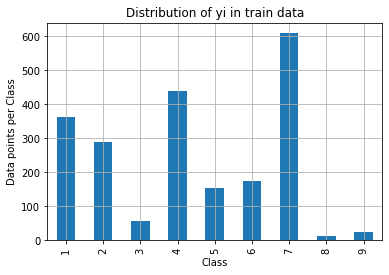

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [15]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()
sorted_i = np.argsort(-train_class_distribution.values)
for i in sorted_i:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

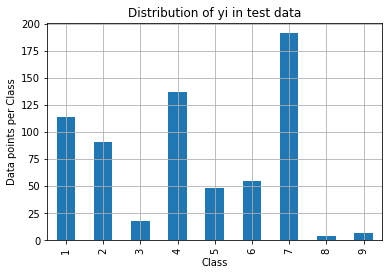

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [16]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()
sorted_i = np.argsort(-test_class_distribution.values)
for i in sorted_i:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

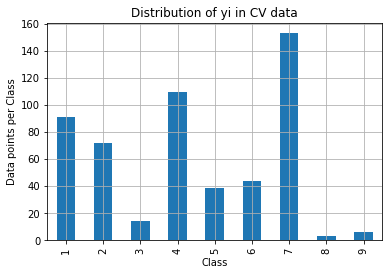

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [17]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in CV data')
plt.grid()
plt.show()
sorted_i = np.argsort(-cv_class_distribution.values)
for i in sorted_i:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

## Prediction using a 'Random' Model

### Confusion matrix plot function

In [18]:
# Code taken from stack overflow

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5006023876980397
Log loss on Test Data using Random Model 2.4698399767723758
-------------------- Confusion matrix --------------------


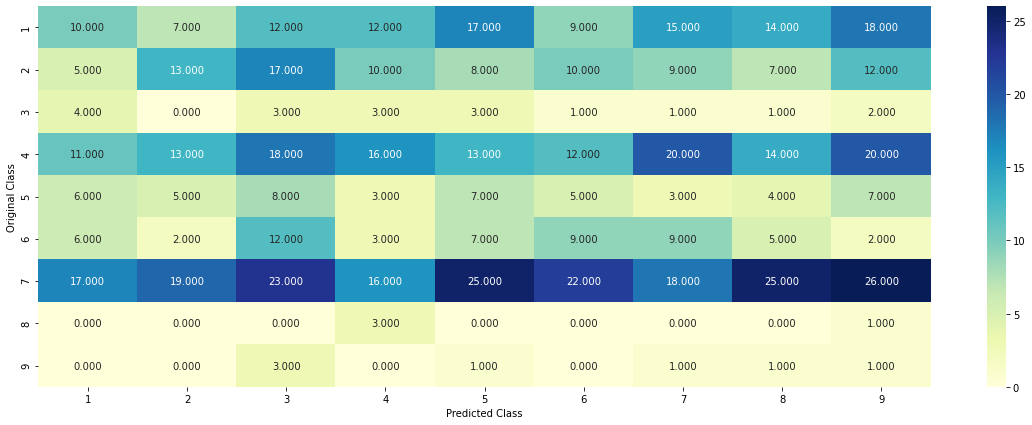

-------------------- Precision matrix (Columm Sum=1) --------------------


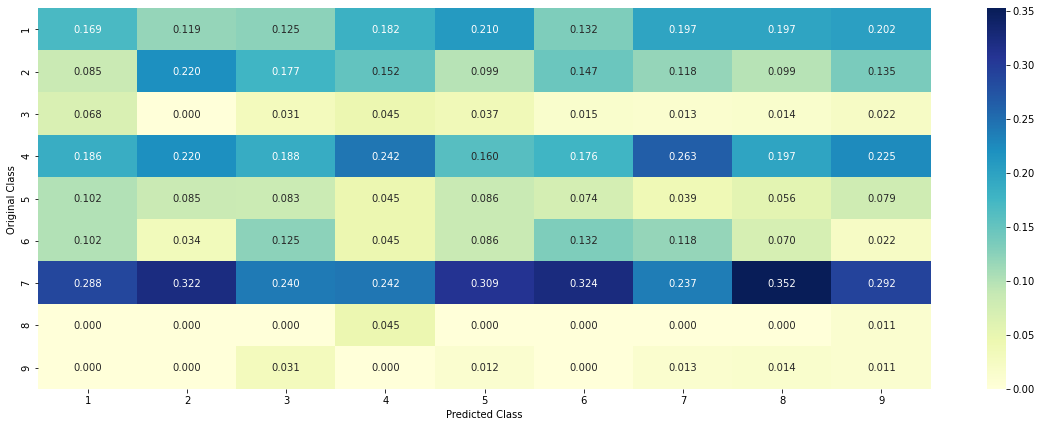

-------------------- Recall matrix (Row sum=1) --------------------


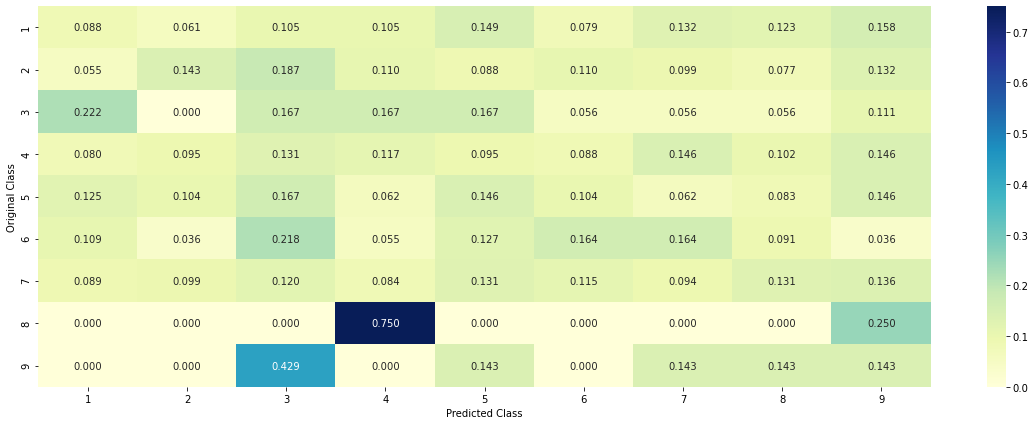

In [19]:
cv_data_len = cv_df.shape[0]
test_data_len = test_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    random_values = np.random.rand(1,9)
    cv_predicted_y[i] = (random_values/np.sum(random_values))[0]
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = (rand_probs/np.sum(rand_probs))[0]
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))
predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# Using the random model we are getting 2.43 as logloss which can be used as base for testing utility of feature

# Feature analysis

### Analysis of Gene feature

In [20]:
unique_genes = train_df['Gene'].value_counts()
print("Total number of unique genes in train data: ",unique_genes.shape[0])
print("Top ten unique gene features: \n",unique_genes[:10])

Total number of unique genes in train data:  236
Top ten unique gene features: 
 BRCA1    169
TP53     103
PTEN      97
EGFR      85
BRCA2     76
KIT       65
BRAF      63
ERBB2     48
ALK       47
TSC2      38
Name: Gene, dtype: int64


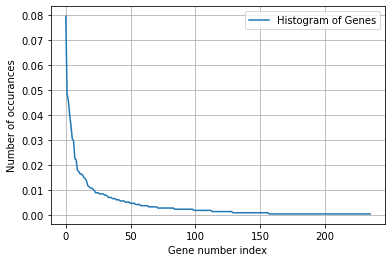

In [21]:
s = np.sum(unique_genes.values)
h = unique_genes.values/s
plt.grid()
plt.plot(h,label = 'Histogram of Genes')
plt.xlabel('Gene number index')
plt.ylabel('Number of occurances')
plt.legend()
# Many Gene occur just one time

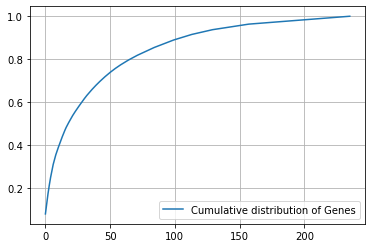

In [22]:
c = np.cumsum(h)
plt.grid()
plt.plot(c,label = 'Cumulative distribution of Genes')
plt.legend()

# Around 50 Genes cover atleast 75% of overall Gene data which shows that the data is highly imbalaned

### Encoding the Gene feature values

#### Have used two ways to encode:
* Response encoding
* TF_IDF encoding

### Response coding

In [23]:
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , 
# the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)


def get_gv_feat_dict(alpha,feature,df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i,denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict




In [24]:
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_feat_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts ()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [25]:
alpha=1
train_gene_feature_resp_encoding = np.array(get_gv_feature(alpha,'Gene',train_df))
test_gene_feature_resp_encoding = np.array(get_gv_feature(alpha,'Gene',test_df))
cv_gene_feature_resp_encoding = np.array(get_gv_feature(alpha,'Gene',cv_df))

### TF_IDF encoding

In [26]:
gene_vector_tf_idf = TfidfVectorizer()
train_gene_feature_tf_idf = gene_vector_tf_idf.fit_transform(train_df['Gene'])
test_gene_feature_tf_idf = gene_vector_tf_idf.transform(test_df['Gene'])
cv_gene_feature_tf_idf = gene_vector_tf_idf.transform(cv_df['Gene'])


## How much important is Gene Feature in predicting Class

For values of alpha =  1e-05 The log loss is: 1.197186477186649
For values of alpha =  0.0001 The log loss is: 1.1838354366803656
For values of alpha =  0.001 The log loss is: 1.2499802503405262
For values of alpha =  0.01 The log loss is: 1.3851565127939407
For values of alpha =  0.1 The log loss is: 1.466506183187715
For values of alpha =  1 The log loss is: 1.5007222322070715
For values of alpha =  10 The log loss is: 1.5053058937347312


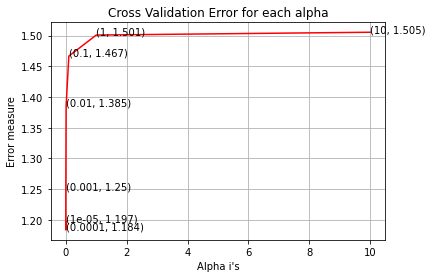

The train log-loss is:  0.9904938808555382
The CV log-loss is:  1.1838354366803656
The test log-loss is:  1.195561815804163


In [27]:
# Here I am predeicting class using only Gene feature

alpha = [10**x for x in range(-5,2)]

cv_log_error =[]
for i in alpha:
    clf = SGDClassifier(alpha=i,loss = 'log',random_state=42)
    clf.fit(train_gene_feature_tf_idf,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(train_gene_feature_tf_idf,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_tf_idf)
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",cv_log_error[-1])


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='r')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],random_state=42,loss='log')
clf.fit(train_gene_feature_tf_idf,y_train)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(train_gene_feature_tf_idf,y_train)

y_predict = sig_clf.predict_proba(train_gene_feature_tf_idf)
print('The train log-loss is: ',log_loss(y_train,y_predict))
y_predict = sig_clf.predict_proba(cv_gene_feature_tf_idf)
print('The CV log-loss is: ',log_loss(y_cv,y_predict))
y_predict = sig_clf.predict_proba(test_gene_feature_tf_idf)
print('The test log-loss is: ',log_loss(y_test,y_predict))

#### Clearly this feature is useful as earlier using random model we were getting error of 2.5

### Is Gene feature stable across all data sets

* To check that we will calculate test and cv coverage, it means how many data points in train data set are covered by test and cv datasets

In [28]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Test data coverage is: ', (test_coverage/test_df.shape[0])*100)
print('Cv data coverage is: ',(cv_coverage/cv_df.shape[0])*100)

Test data coverage is:  96.99248120300751
Cv data coverage is:  97.55639097744361


# Analysing Variation feature

In [29]:
Unique_variation = train_df['Variation'].value_counts()
print('Total number of unique variation present in train data: ',Unique_variation.shape[0])
print('Top Variations are: \n',Unique_variation[:10])

Total number of unique variation present in train data:  1931
Top Variations are: 
 Truncating_Mutations    56
Deletion                49
Amplification           47
Fusions                 22
Overexpression           3
E17K                     3
Q61H                     3
F384L                    2
P34R                     2
Q22K                     2
Name: Variation, dtype: int64


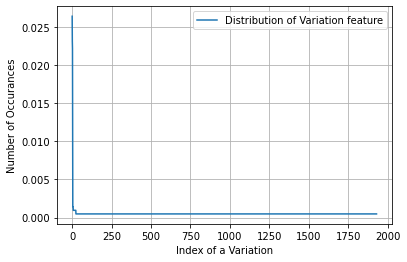

In [30]:
s = np.sum(Unique_variation.values)
h = Unique_variation.values/s
plt.grid()
plt.plot(h,label = 'Distribution of Variation feature')
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()

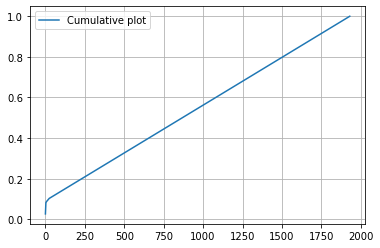

In [31]:
c = np.cumsum(h)
plt.grid()
plt.plot(c,label = 'Cumulative plot')
plt.legend()

## Encoding the Variation feature

### Response Encoding

In [32]:
alpha=1
train_variation_resp_encoding = np.array(get_gv_feature(alpha,'Variation',train_df))
cv_variation_resp_encoding = np.array(get_gv_feature(alpha,'Variation',cv_df))
test_variation_resp_encoding = np.array(get_gv_feature(alpha,'Variation',test_df))

### Tf_IDF encoding

In [33]:
variation_tfi_df = TfidfVectorizer()
train_variation_tf_idf_encoding = variation_tfi_df.fit_transform(train_df['Variation'])
cv_variation_tf_idf_encoding = variation_tfi_df.transform(cv_df['Variation'])
test_variation_tf_idf_encoding = variation_tfi_df.transform(test_df['Variation'])

## How much important is Variation Feature in predicting Class

For values of alpha =  1e-05 The log loss is: 1.6973173903773713
For values of alpha =  0.0001 The log loss is: 1.6932479952923476
For values of alpha =  0.001 The log loss is: 1.6981502469374545
For values of alpha =  0.01 The log loss is: 1.6991091283805981
For values of alpha =  0.1 The log loss is: 1.7126874826481173
For values of alpha =  1 The log loss is: 1.7146291769580135
For values of alpha =  10 The log loss is: 1.714847801720255


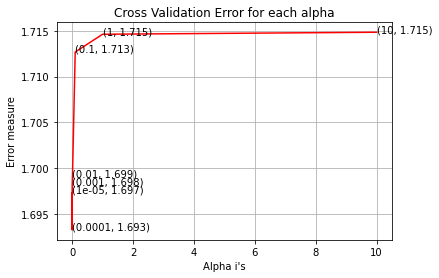

The train log-loss is:  0.7067504993350827
The CV log-loss is:  1.6932479952923476
The test log-loss is:  1.697583876528317


In [34]:
alpha = [10**x for x in range(-5,2)]

cv_log_error =[]
for i in alpha:
    clf = SGDClassifier(alpha=i,loss = 'log',random_state=42)
    clf.fit(train_variation_tf_idf_encoding,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(train_variation_tf_idf_encoding,y_train)
    predict_y = sig_clf.predict_proba(cv_variation_tf_idf_encoding)
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",cv_log_error[-1])


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='r')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],random_state=42,loss='log')
clf.fit(train_variation_tf_idf_encoding,y_train)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(train_variation_tf_idf_encoding,y_train)

y_predict = sig_clf.predict_proba(train_variation_tf_idf_encoding)
print('The train log-loss is: ',log_loss(y_train,y_predict))
y_predict = sig_clf.predict_proba(cv_variation_tf_idf_encoding)
print('The CV log-loss is: ',log_loss(y_cv,y_predict))
y_predict = sig_clf.predict_proba(test_variation_tf_idf_encoding)
print('The test log-loss is: ',log_loss(y_test,y_predict))

#### Clearly this feature is useful as earlier using random model we were getting error of 2.5

### Is Gene feature stable across all data sets

* To check that we will calculate test and cv coverage, it means how many data points in train data set are covered by test and cv datasets

In [35]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Test data coverage is: ', (test_coverage/test_df.shape[0])*100)
print('Cv data coverage is: ',(cv_coverage/cv_df.shape[0])*100)

Test data coverage is:  10.37593984962406
Cv data coverage is:  10.338345864661653


#### The test Coverage is very less and therefore we can see huge difference in the train and test,cv losses

# Analysis of TEXT feature

* Will encode the text with response and tf_idf encoding

#### Response encoding for TEXT feature

In [36]:
# This function will give the count of the words present in a feature for a given dataframe
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [37]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

In [38]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [39]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [40]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [41]:
train_text_feature_responseCoding = np.array(train_text_feature_responseCoding)
test_text_feature_responseCoding = np.array(test_text_feature_responseCoding)
cv_text_feature_responseCoding = np.array(cv_text_feature_responseCoding)

#### Tf_IDF encoding

In [42]:
text_tf_idf_vectorizer = TfidfVectorizer(min_df=3)
train_text_tfi_df = text_tf_idf_vectorizer.fit_transform(train_df['TEXT'])
cv_text_tfi_df = text_tf_idf_vectorizer.transform(cv_df['TEXT'])
test_text_tfi_df = text_tf_idf_vectorizer.transform(test_df['TEXT'])

### Sorting the text word to get the important words based on it's tf-idf values

In [43]:
train_text_features = text_tf_idf_vectorizer.get_feature_names()
train_text_fea_counts = train_text_tfi_df.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))

In [44]:
sorted_text_fea_dict


{'mutations': 157.95880930145665,
 'brca1': 109.7831388229191,
 'cells': 99.17685469814911,
 'variants': 81.00000854815458,
 'pten': 75.97836916254707,
 'fig': 75.26515115137883,
 'mutation': 70.57780384395325,
 'al': 70.41744825558783,
 'et': 70.12600118633864,
 'cell': 70.06966203234148,
 'cancer': 66.22927089886613,
 'figure': 59.618700743953525,
 'egfr': 57.32018280773605,
 'p53': 57.131724463342664,
 'patients': 55.400562700185596,
 'activity': 51.33856383162063,
 'protein': 51.110543672617744,
 'kinase': 47.87269843993239,
 'mutant': 47.191383520117355,
 'tumor': 46.4234099104627,
 'type': 46.12453422985306,
 'domain': 42.27922658080326,
 'expression': 42.21819665271489,
 'mutants': 41.049327037461026,
 'brct': 40.5978493516061,
 'alk': 39.745601565500294,
 'binding': 39.3661610253156,
 'data': 38.78239282409329,
 'wild': 38.771306092561026,
 'using': 38.39008478137442,
 'vus': 38.04296326911359,
 'tumors': 37.77344457485603,
 'also': 37.66342408645014,
 'gene': 36.64973327741244

## How much important is Variation Feature in predicting Class

For values of alpha =  1e-05 The log loss is: 1.1002010833938884
For values of alpha =  0.0001 The log loss is: 1.0780205060712178
For values of alpha =  0.001 The log loss is: 1.179583130809097
For values of alpha =  0.01 The log loss is: 1.3643065713185152
For values of alpha =  0.1 The log loss is: 1.5643366425918632
For values of alpha =  1 The log loss is: 1.6252914639356437
For values of alpha =  10 The log loss is: 1.6323125190547367


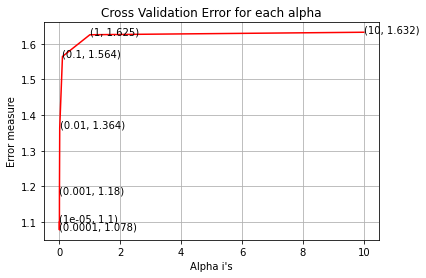

The train log-loss is:  0.6633239068748277
The CV log-loss is:  1.0780205060712178
The test log-loss is:  0.9768585251547035


In [45]:
alpha = [10**x for x in range(-5,2)]

cv_log_error =[]
for i in alpha:
    clf = SGDClassifier(alpha=i,loss = 'log',random_state=42)
    clf.fit(train_text_tfi_df,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(train_text_tfi_df,y_train)
    predict_y = sig_clf.predict_proba(cv_text_tfi_df)
    cv_log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",cv_log_error[-1])


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='r')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha],random_state=42,loss='log')
clf.fit(train_text_tfi_df,y_train)
sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(train_text_tfi_df,y_train)

y_predict = sig_clf.predict_proba(train_text_tfi_df)
print('The train log-loss is: ',log_loss(y_train,y_predict))
y_predict = sig_clf.predict_proba(cv_text_tfi_df)
print('The CV log-loss is: ',log_loss(y_cv,y_predict))
y_predict = sig_clf.predict_proba(test_text_tfi_df)
print('The test log-loss is: ',log_loss(y_test,y_predict))

#### Clearly TEXT feature is reducing the log-loss error

### Checking test and CV coverage

In [46]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [47]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.268 % of word of test data appeared in train data
97.637 % of word of Cross Validation appeared in train data


# Machine Learning models

### Stacking three types of features

In [48]:
# Stacking TF_IDF encoded features

train_x_tf_idf = hstack((train_gene_feature_tf_idf,train_variation_tf_idf_encoding,train_text_tfi_df)).tocsr()
cv_x_tf_idf = hstack((cv_gene_feature_tf_idf,cv_variation_tf_idf_encoding,cv_text_tfi_df)).tocsr()
test_x_tf_idf = hstack((test_gene_feature_tf_idf,test_variation_tf_idf_encoding,test_text_tfi_df)).tocsr()
                                  
#Stacking Response encoded features

train_x_resp_encoding = np.hstack((train_gene_feature_resp_encoding,train_variation_resp_encoding,train_text_feature_responseCoding))
cv_x_resp_encoding = np.hstack((cv_gene_feature_resp_encoding,cv_variation_resp_encoding,cv_text_feature_responseCoding))                                   
test_x_resp_encoding = np.hstack((test_gene_feature_resp_encoding,test_variation_resp_encoding,test_text_feature_responseCoding))                                   


train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

In [49]:
print("TF_IDF encoding features :")
print("(number of data points * number of features) in train data = ", train_x_tf_idf.shape)
print("(number of data points * number of features) in test data = ", test_x_tf_idf.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_tf_idf.shape)
print('*******************************************************************************************************')
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_resp_encoding.shape)
print("(number of data points * number of features) in test data = ", test_x_resp_encoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_resp_encoding.shape)

TF_IDF encoding features :
(number of data points * number of features) in train data =  (2124, 57559)
(number of data points * number of features) in test data =  (665, 57559)
(number of data points * number of features) in cross validation data = (532, 57559)
*******************************************************************************************************
 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Using Naive Bias model

for alpha = 1e-05
Log Loss : 1.1863448473161429
for alpha = 0.0001
Log Loss : 1.1811979989209924
for alpha = 0.001
Log Loss : 1.1707570196662715
for alpha = 0.1
Log Loss : 1.2074442872342401
for alpha = 1
Log Loss : 1.25124642622751
for alpha = 10
Log Loss : 1.2617010138824143
for alpha = 100
Log Loss : 1.3127721536640513
for alpha = 1000
Log Loss : 1.3238871521985682


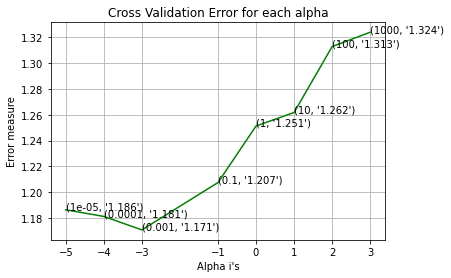

In [50]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tf_idf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tf_idf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tf_idf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()




#### Testing the model with best hyperparameters

For values of best alpha =  0.001 The train log loss is: 0.6101681263430179
For values of best alpha =  0.001 The cross validation log loss is: 1.1707570196662715
For values of best alpha =  0.001 The test log loss is: 1.1140257074158653
-------------------- Confusion matrix --------------------


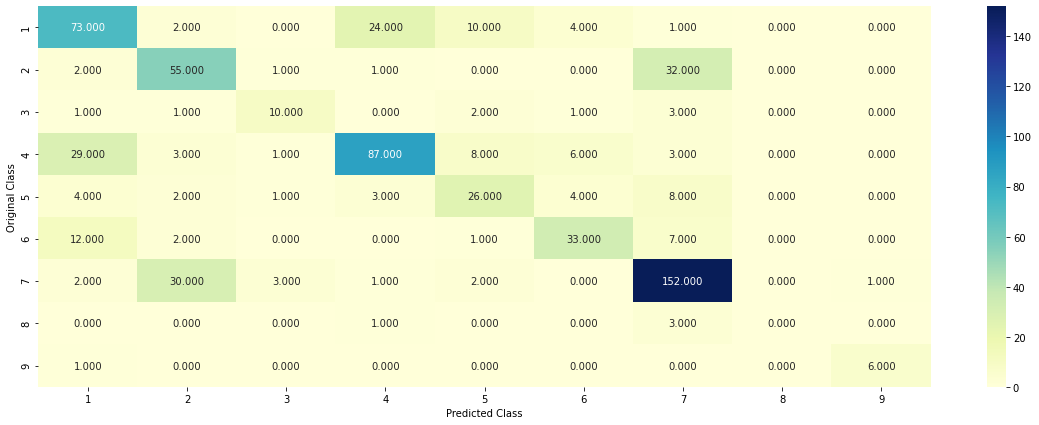

-------------------- Precision matrix (Columm Sum=1) --------------------


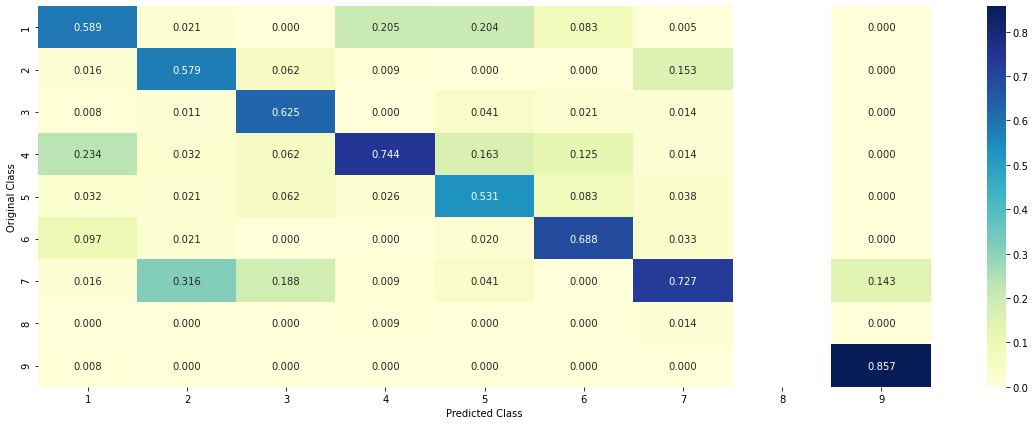

-------------------- Recall matrix (Row sum=1) --------------------


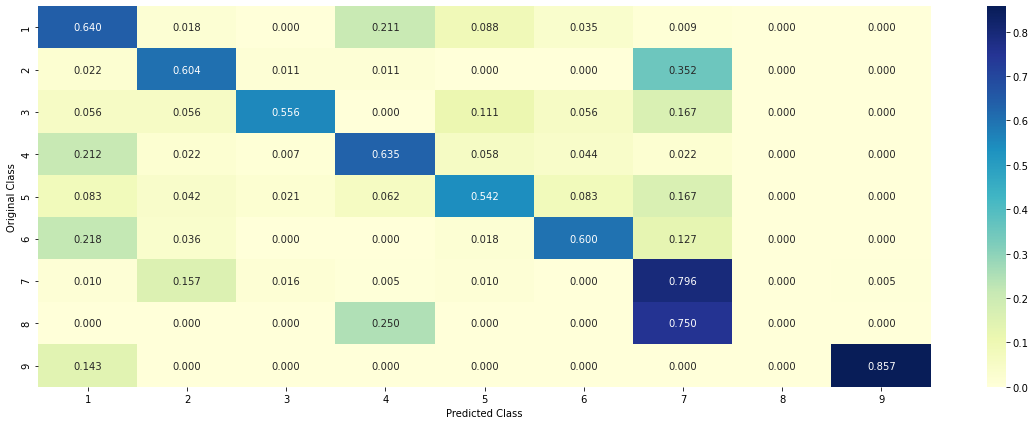

In [51]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tf_idf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tf_idf, train_y)


predict_y = sig_clf.predict_proba(train_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)

### Finding the important features of the model

In [52]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [53]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tf_idf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tf_idf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0849 0.264  0.0161 0.0955 0.0411 0.0413 0.4453 0.0058 0.006 ]]
Actual Class : 7
--------------------------------------------------
1 Text feature [mutations] present in test data point [True]
2 Text feature [cells] present in test data point [True]
3 Text feature [egfr] present in test data point [True]
7 Text feature [cell] present in test data point [True]
8 Text feature [alk] present in test data point [True]
9 Text feature [fig] present in test data point [True]
13 Text feature [kinase] present in test data point [True]
15 Text feature [patients] present in test data point [True]
16 Text feature [mutation] present in test data point [True]
18 Text feature [al] present in test data point [True]
19 Text feature [et] present in test data point [True]
20 Text feature [raf] present in test data point [True]
22 Text feature [figure] present in test data point [True]
26 Text feature [cancer] present in test data point [True]
28 Text f

# K-Nearest Neighbors

#### Using response encoding as KNN works best when dimensions are less

for alpha = 5
Log Loss : 1.0917811699817423
for alpha = 11
Log Loss : 1.0640806761663422
for alpha = 15
Log Loss : 1.0705997219321062
for alpha = 21
Log Loss : 1.0866688811308844
for alpha = 31
Log Loss : 1.102803103356925
for alpha = 41
Log Loss : 1.1031911081263657
for alpha = 51
Log Loss : 1.1091401528924674
for alpha = 99
Log Loss : 1.1178571839880236


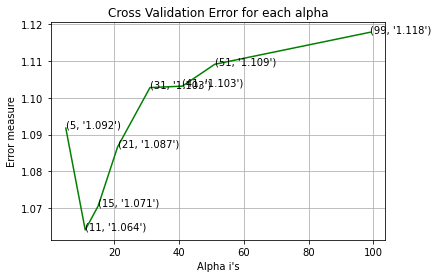

In [54]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i,)
    clf.fit(train_x_resp_encoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_resp_encoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_resp_encoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  11 The train log loss is: 0.6016042504470052
For values of best alpha =  11 The cross validation log loss is: 1.0640806761663422
For values of best alpha =  11 The test log loss is: 1.0432580610262996
-------------------- Confusion matrix --------------------


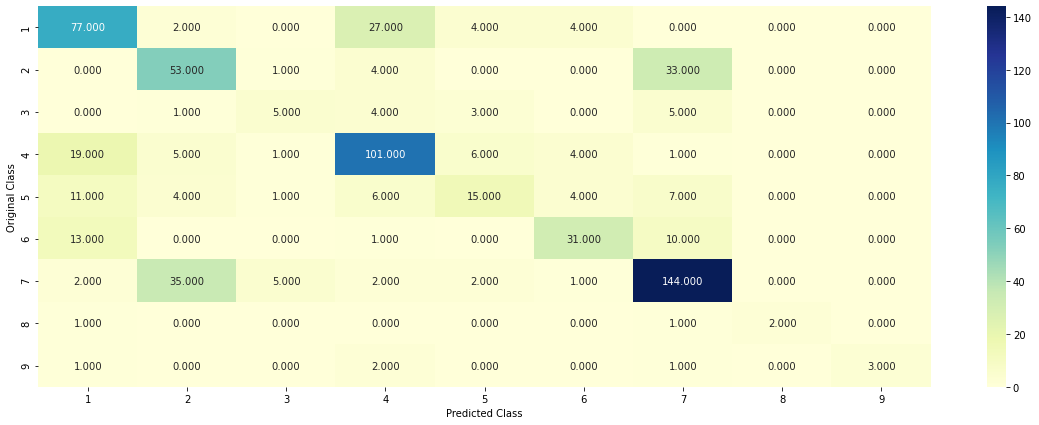

-------------------- Precision matrix (Columm Sum=1) --------------------


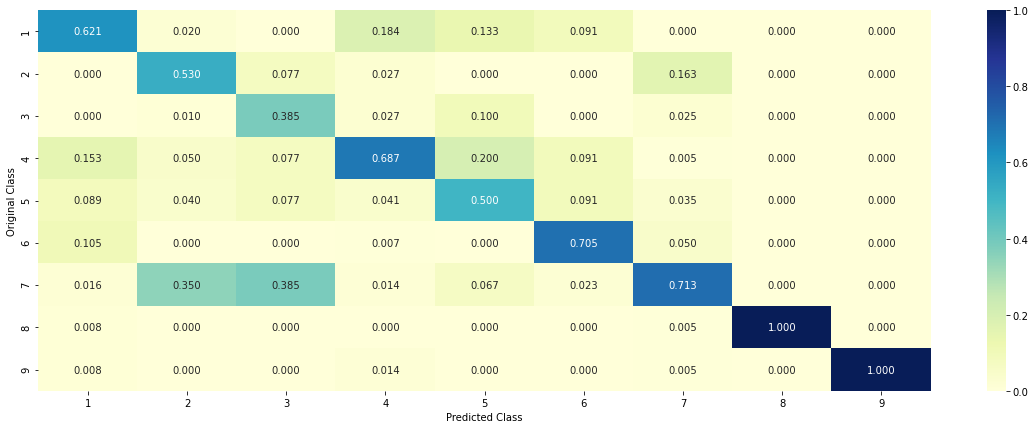

-------------------- Recall matrix (Row sum=1) --------------------


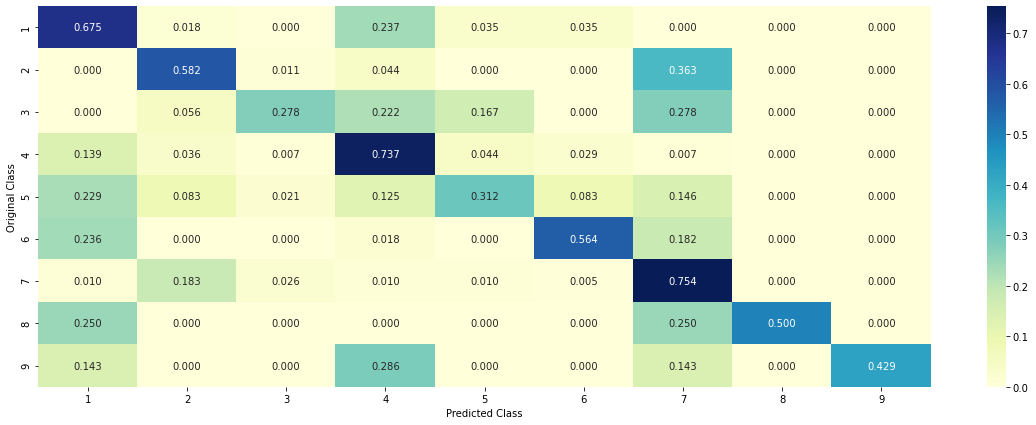

In [55]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_resp_encoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_resp_encoding, train_y)

predict_y = sig_clf.predict_proba(train_x_resp_encoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_resp_encoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_resp_encoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)

### Analysing test point

In [56]:


test_point_index = 1
predicted_cls = sig_clf.predict(test_x_resp_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_resp_encoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 4 4 4 4 4]
Fequency of nearest points : Counter({4: 11})


In [57]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_resp_encoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_resp_encoding, train_y)

test_point_index = 106
predicted_cls = sig_clf.predict(test_x_resp_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_resp_encoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [1 1 1 1 1 4 3 4 1 1 1]
Fequency of nearest points : Counter({1: 8, 4: 2, 3: 1})


# Logistic Regression with Balanced weights

for alpha = 1e-06
Log Loss : 1.1332863766249155
for alpha = 1e-05
Log Loss : 1.0081729833169901
for alpha = 0.0001
Log Loss : 0.9836534306928864
for alpha = 0.001
Log Loss : 1.0597396855685925
for alpha = 0.01
Log Loss : 1.2371297088608273
for alpha = 0.1
Log Loss : 1.450825838787659
for alpha = 1
Log Loss : 1.5221397252532962
for alpha = 10
Log Loss : 1.5329338772475944
for alpha = 100
Log Loss : 1.5342613328464456


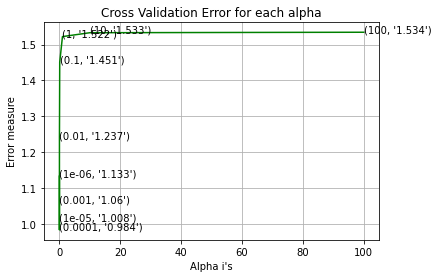

In [58]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tf_idf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tf_idf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tf_idf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.0001 The train log loss is: 0.3779655437777851
For values of best alpha =  0.0001 The cross validation log loss is: 0.9836534306928864
For values of best alpha =  0.0001 The test log loss is: 0.9356378189533535
-------------------- Confusion matrix --------------------


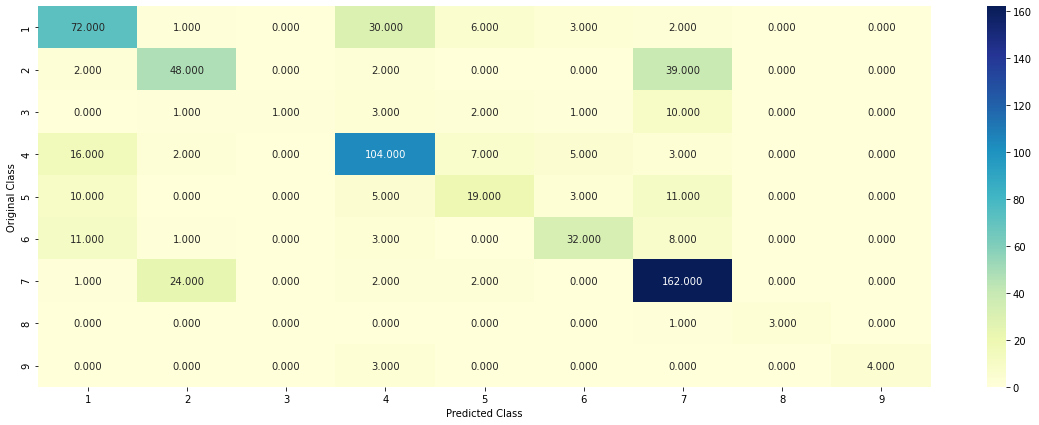

-------------------- Precision matrix (Columm Sum=1) --------------------


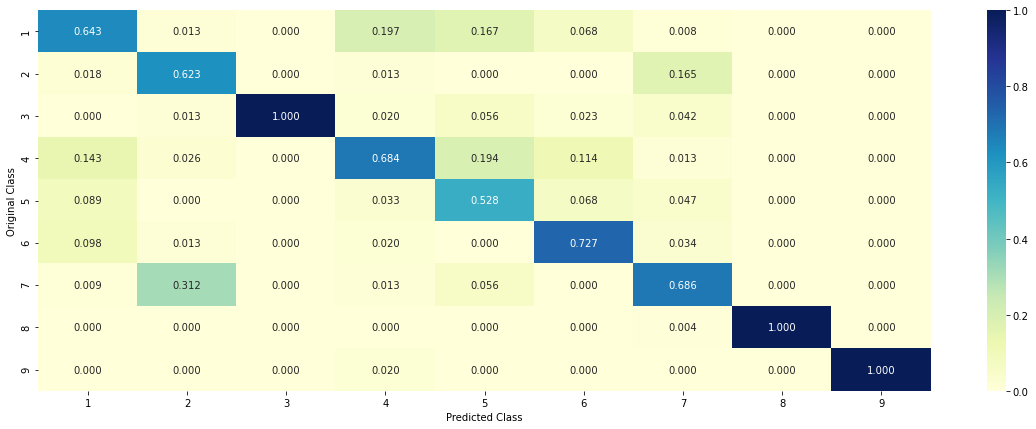

-------------------- Recall matrix (Row sum=1) --------------------


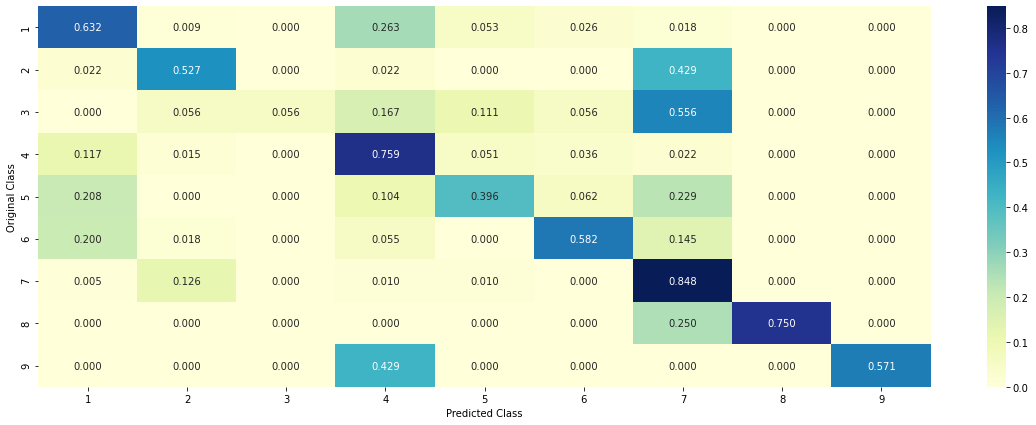

In [59]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tf_idf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tf_idf, train_y)

predict_y = sig_clf.predict_proba(train_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)


### Analysis of test point

In [60]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tf_idf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tf_idf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0165 0.0071 0.0634 0.8837 0.0132 0.0044 0.0059 0.0038 0.002 ]]
Actual Class : 4
--------------------------------------------------
48 Text feature [pten] present in test data point [True]
Out of the top  100  features  1 are present in query point


# Logistic Regression without Class Weight Balancing

for alpha = 1e-06
Log Loss : 1.154685543264044
for alpha = 1e-05
Log Loss : 1.0193446569081779
for alpha = 0.0001
Log Loss : 0.9823969300600327
for alpha = 0.001
Log Loss : 1.053672338795499
for alpha = 0.01
Log Loss : 1.2218739879991583
for alpha = 0.1
Log Loss : 1.3899203726079934
for alpha = 1
Log Loss : 1.47650301666318
for alpha = 10
Log Loss : 1.4886396914891193
for alpha = 100
Log Loss : 1.4901438472872361


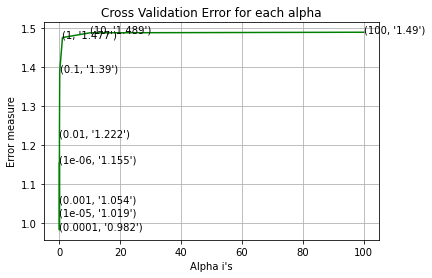

In [61]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tf_idf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tf_idf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tf_idf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.0001 The train log loss is: 0.3655060201309211
For values of best alpha =  0.0001 The cross validation log loss is: 0.9823969300600327
For values of best alpha =  0.0001 The test log loss is: 0.9350497380839621
-------------------- Confusion matrix --------------------


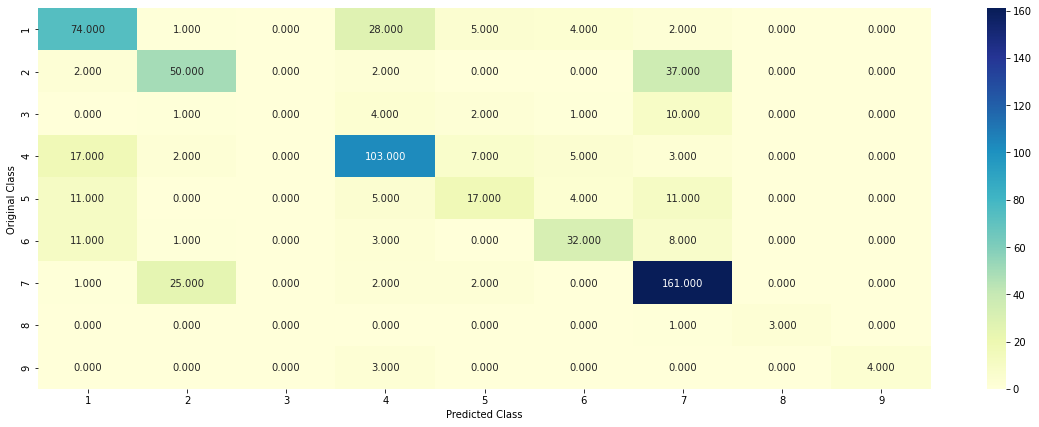

-------------------- Precision matrix (Columm Sum=1) --------------------


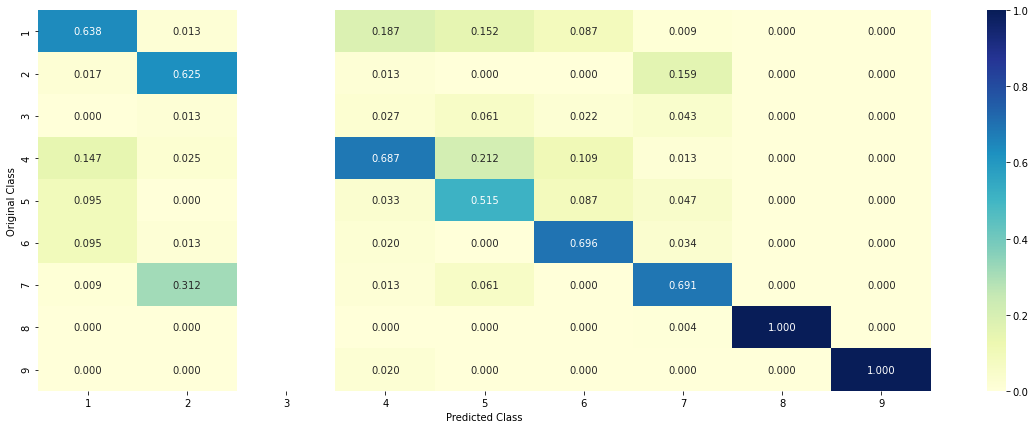

-------------------- Recall matrix (Row sum=1) --------------------


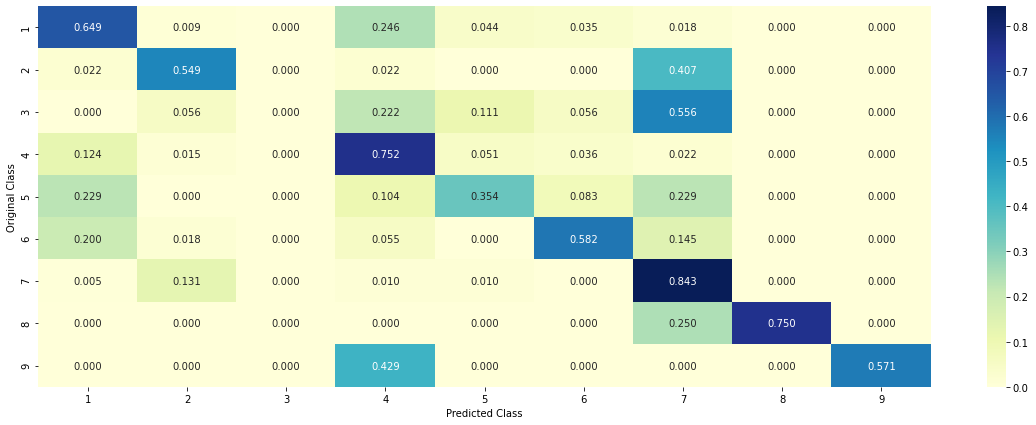

In [62]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tf_idf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tf_idf, train_y)

predict_y = sig_clf.predict_proba(train_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)


# Linear SVM with class weight balanced

for alpha = 1e-06
Log Loss : 1.13823501781985
for alpha = 1e-05
Log Loss : 1.0865711738355208
for alpha = 0.0001
Log Loss : 1.021793559750812
for alpha = 0.001
Log Loss : 1.1028444214385928
for alpha = 0.01
Log Loss : 1.3062036465853089
for alpha = 0.1
Log Loss : 1.4604723420537689
for alpha = 1
Log Loss : 1.5346535071382905
for alpha = 10
Log Loss : 1.534653475154446
for alpha = 100
Log Loss : 1.5346594061631567


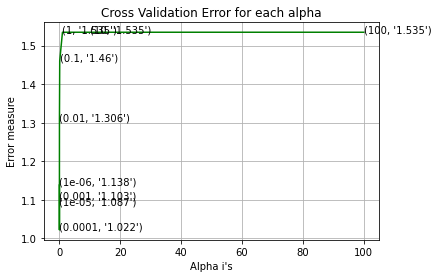

In [63]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tf_idf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tf_idf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tf_idf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  0.0001 The train log loss is: 0.3779655437777851
For values of best alpha =  0.0001 The cross validation log loss is: 0.9836534306928864
For values of best alpha =  0.0001 The test log loss is: 0.9356378189533535
-------------------- Confusion matrix --------------------


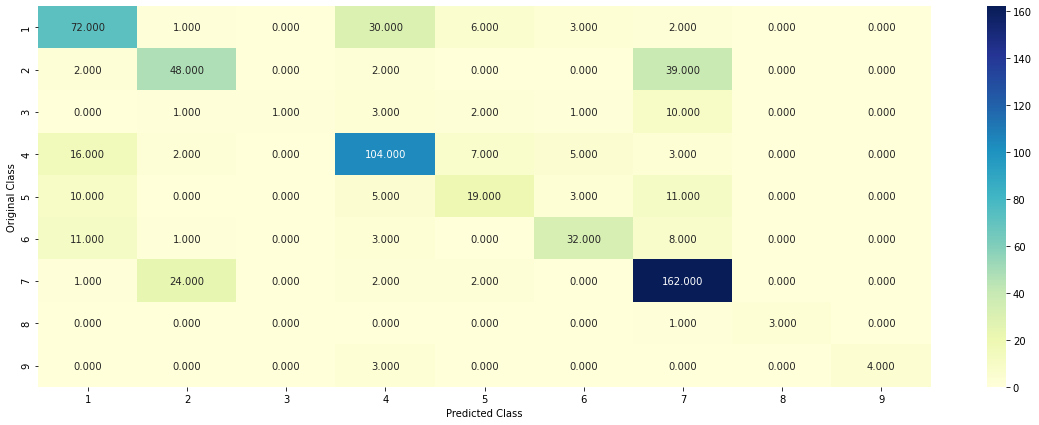

-------------------- Precision matrix (Columm Sum=1) --------------------


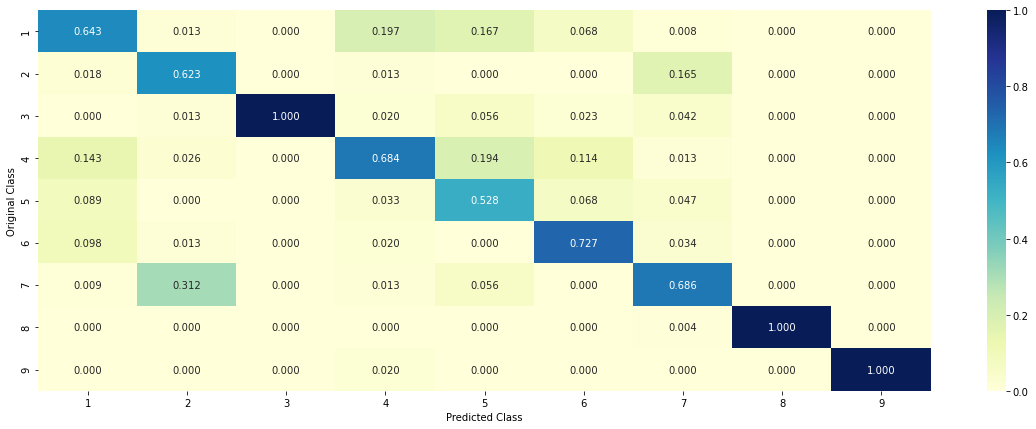

-------------------- Recall matrix (Row sum=1) --------------------


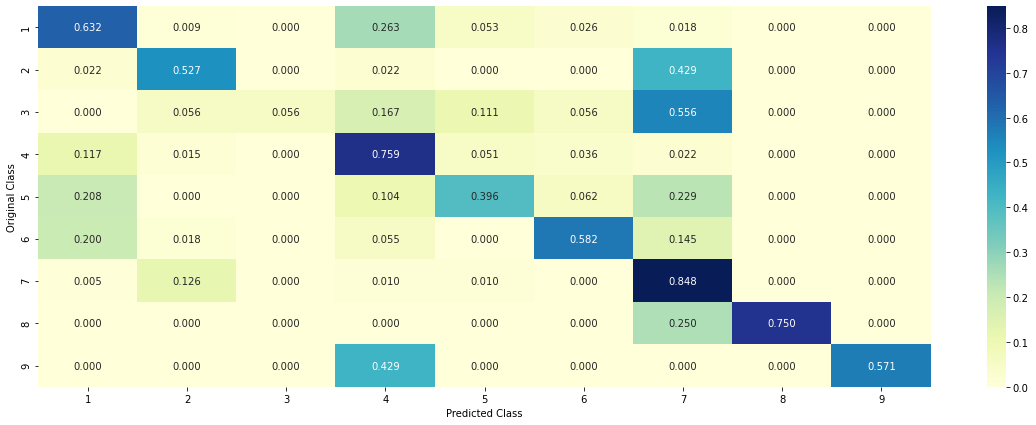

In [64]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tf_idf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tf_idf, train_y)

predict_y = sig_clf.predict_proba(train_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tf_idf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)

### Analysis of point

In [66]:
test_point_index = 5
no_feature = 100
predicted_cls = sig_clf.predict(test_x_tf_idf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_tf_idf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 8
Predicted Class Probabilities: [[0.1281 0.1459 0.0211 0.1834 0.0489 0.0347 0.1209 0.3041 0.013 ]]
Actual Class : 8
--------------------------------------------------
26 Text feature [idh] present in test data point [True]
27 Text feature [h3] present in test data point [True]
31 Text feature [methylation] present in test data point [True]
35 Text feature [h3f3a] present in test data point [True]
40 Text feature [idh2] present in test data point [True]
43 Text feature [gbm] present in test data point [True]
50 Text feature [atrx] present in test data point [True]
51 Text feature [transcripts] present in test data point [True]
53 Text feature [histone] present in test data point [True]
58 Text feature [g34] present in test data point [True]
71 Text feature [k27] present in test data point [True]
73 Text feature [paediatric] present in test data point [True]
74 Text feature [aberrant] present in test data point [True]
87 Text feature [subtype] present in test data poin

# Random Forest Classifier (Using response encoding)

for n_estimators = 100 and max depth =  5
Log Loss : 1.3275949467411579
for n_estimators = 100 and max depth =  10
Log Loss : 1.6068035359525148
for n_estimators = 200 and max depth =  5
Log Loss : 1.3859827328308312
for n_estimators = 200 and max depth =  10
Log Loss : 1.661506979404453
for n_estimators = 500 and max depth =  5
Log Loss : 1.3936469322518372
for n_estimators = 500 and max depth =  10
Log Loss : 1.6981383718588834
for n_estimators = 1000 and max depth =  5
Log Loss : 1.3941847224316166
for n_estimators = 1000 and max depth =  10
Log Loss : 1.6818092932646398
for n_estimators = 2000 and max depth =  5
Log Loss : 1.406532752857551
for n_estimators = 2000 and max depth =  10
Log Loss : 1.6984381222178697


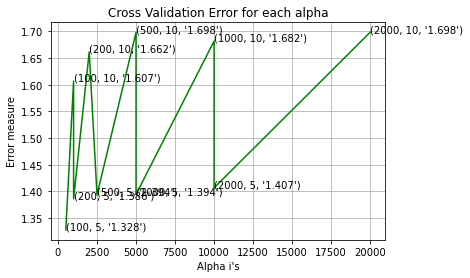

In [67]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_resp_encoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_resp_encoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_resp_encoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best estimator =  100 The train log loss is: 0.06960162239326764
For values of best estimator =  100 The cross validation log loss is: 1.3275949467411579
For values of best estimator =  100 The test log loss is: 1.2452541895067708
-------------------- Confusion matrix --------------------


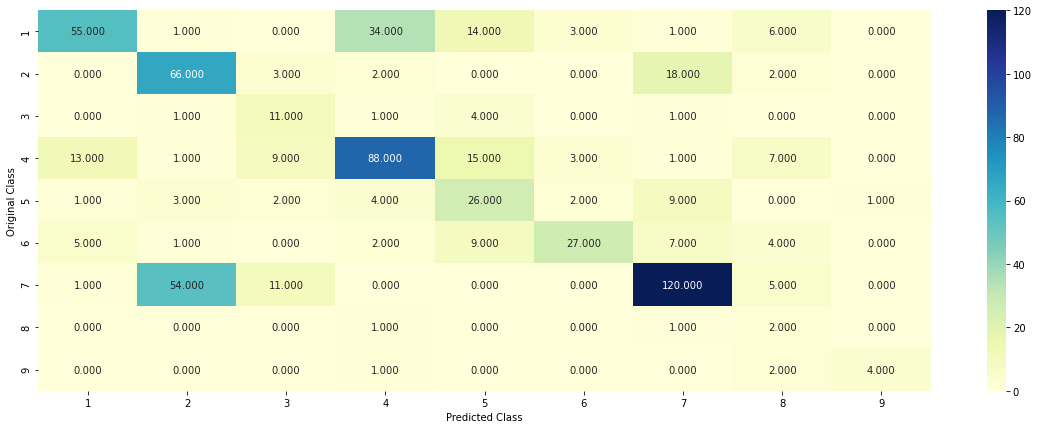

-------------------- Precision matrix (Columm Sum=1) --------------------


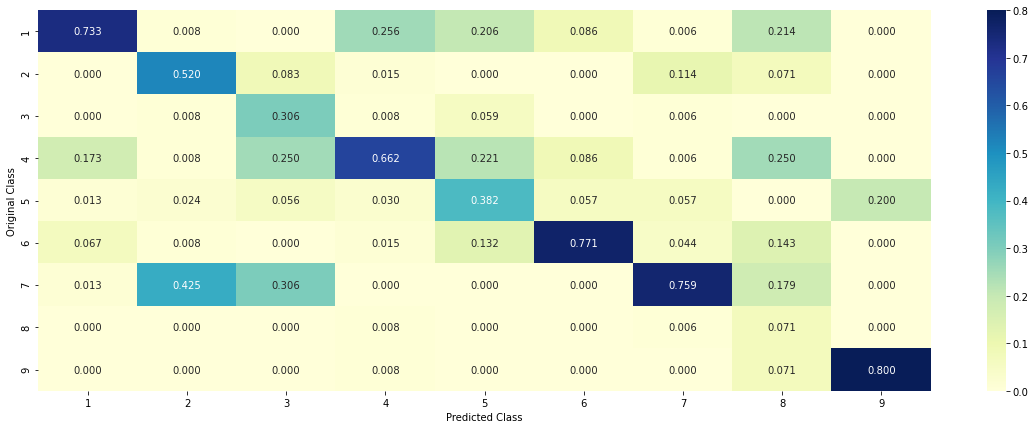

-------------------- Recall matrix (Row sum=1) --------------------


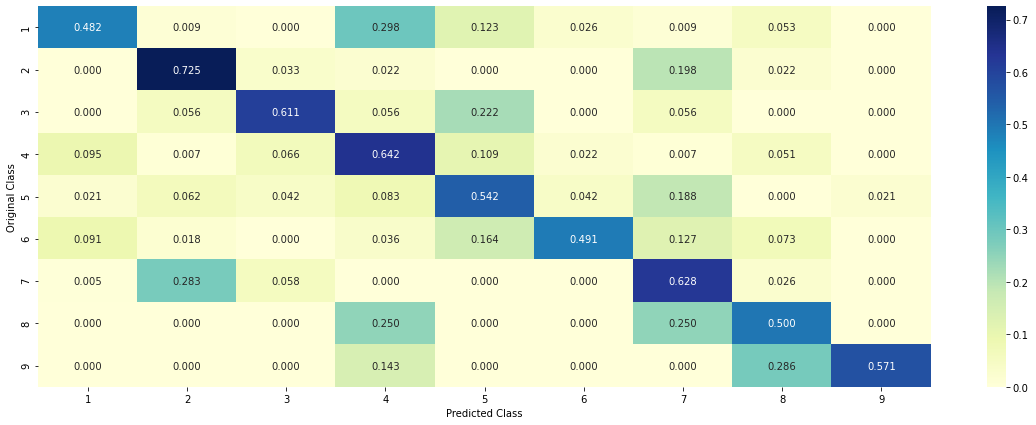

In [68]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_resp_encoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_resp_encoding, train_y)

predict_y = sig_clf.predict_proba(train_x_resp_encoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_resp_encoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_resp_encoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y,predicted_y+1)


# Stacking the models

In [69]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_tf_idf, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_tf_idf, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_tf_idf, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_tf_idf, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_tf_idf))))
sig_clf2.fit(train_x_tf_idf, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_tf_idf))))
sig_clf3.fit(train_x_tf_idf, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_tf_idf))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
log_error = []
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_tf_idf, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_tf_idf))))
    log_error.append(log_loss(cv_y, sclf.predict_proba(cv_x_tf_idf)))

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.53
Naive Bayes : Log Loss: 1.17
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.726
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.333
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.088
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.245
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.511


Log loss (train) on the stacking classifier : 0.4683277155689829
Log loss (CV) on the stacking classifier : 1.0880288979537738
Log loss (test) on the stacking classifier : 1.0839087699403962
Number of missclassified point : 0.3398496240601504
-------------------- Confusion matrix --------------------


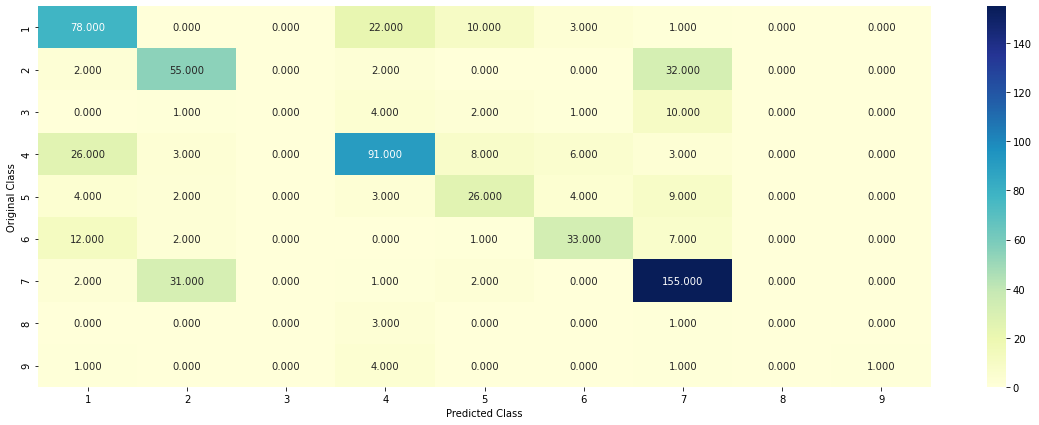

-------------------- Precision matrix (Columm Sum=1) --------------------


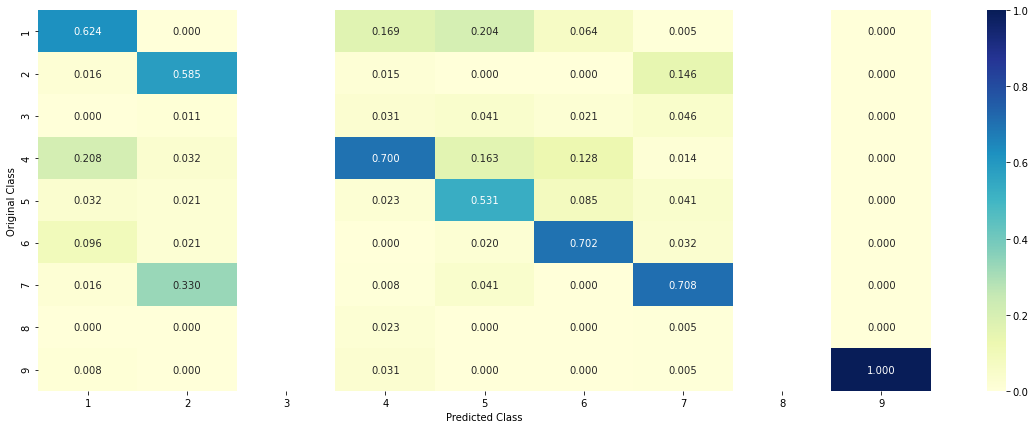

-------------------- Recall matrix (Row sum=1) --------------------


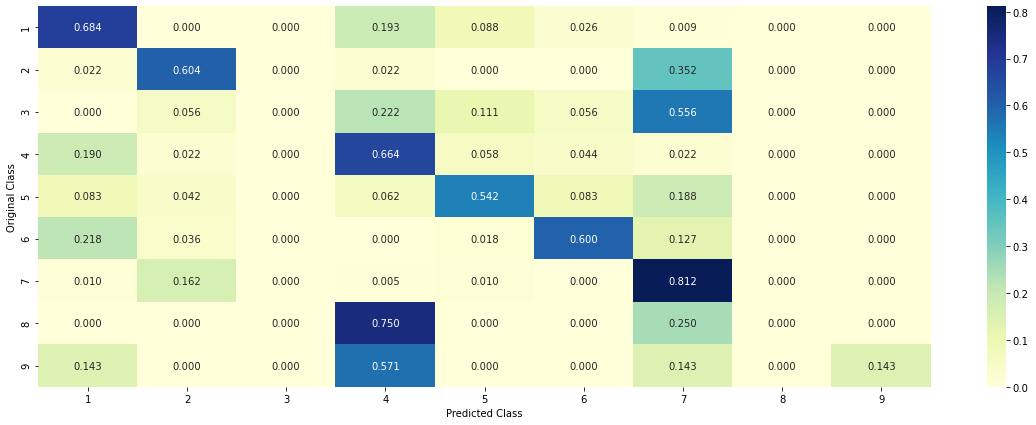

In [73]:
best_alpha = np.argmin(log_error)


lr = LogisticRegression(C=alpha[best_alpha])
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_tf_idf, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_tf_idf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_tf_idf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_tf_idf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_tf_idf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_tf_idf))

# Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8137261142173188
Log loss (CV) on the VotingClassifier : 1.167330753904966
Log loss (test) on the VotingClassifier : 1.1183660199404795
Number of missclassified point : 0.33533834586466166
-------------------- Confusion matrix --------------------


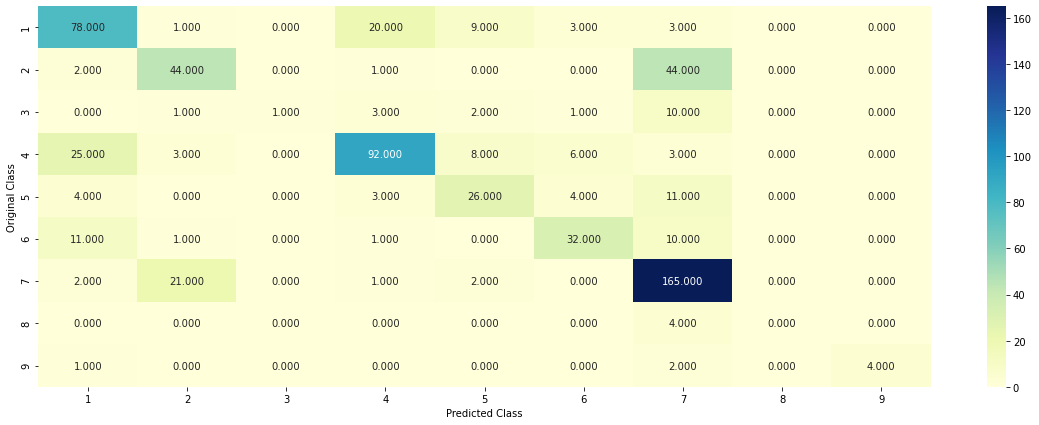

-------------------- Precision matrix (Columm Sum=1) --------------------


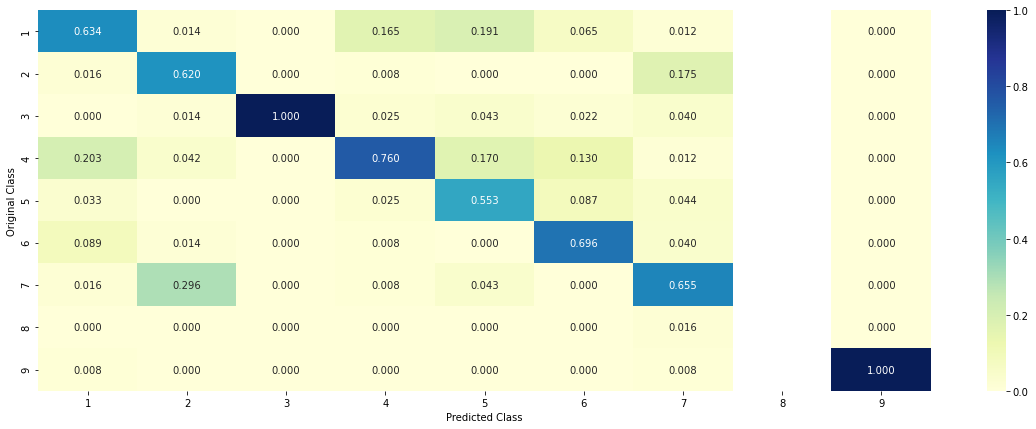

-------------------- Recall matrix (Row sum=1) --------------------


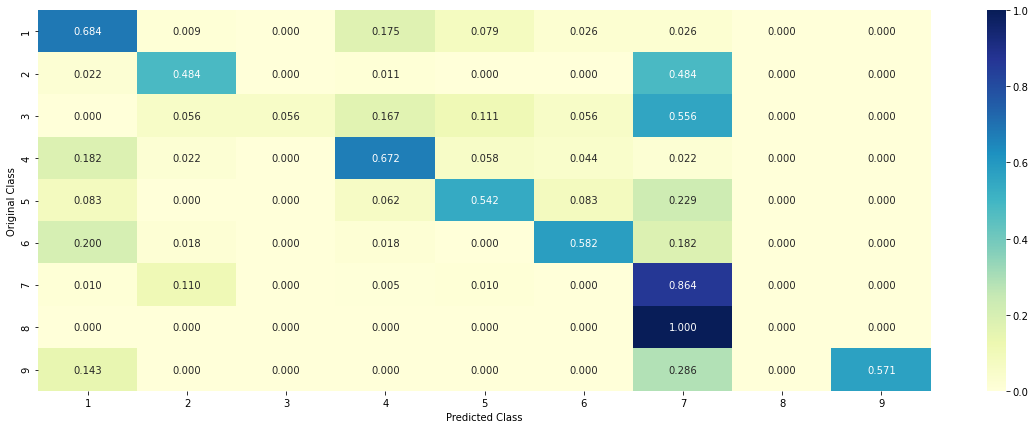

In [74]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_tf_idf, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_tf_idf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_tf_idf)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_tf_idf)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_tf_idf)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_tf_idf))